In [0]:
#加载google drive上的数据集
!echo 'Installing required software'
!apt-get install -y -qq software-properties-common module-init-tools 2>&1 > /dev/null
!echo 'Add apt-repository with Google.Drive Fuse'
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!echo 'Updating packages...'
!apt-get update -y -qq
!echo 'Installing google-drive-ocamlfuse fuse...'
!apt-get install -y -qq google-drive-ocamlfuse fuse
!echo 'Authenticate Fuse in Google.Drive...'
from google.colab import auth
from oauth2client.client import GoogleCredentials
import getpass
auth.authenticate_user()
creds = GoogleCredentials.get_application_default()
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass('Enter auth code here: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!echo 'Authenticated!'
!echo 'Creating mount directory'
!mkdir ./drive2
!echo 'Mounting...'
!google-drive-ocamlfuse ./drive2
!ls ./drive2
!echo 'Mounted!'

Installing required software
Add apt-repository with Google.Drive Fuse
Updating packages...
Installing google-drive-ocamlfuse fuse...
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Authenticate Fuse in Google.Drive...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Enter auth code here: ··········
Please, open the following URL in a web browser: https://accounts.googl

In [0]:
!ls

In [0]:
#解压数据集
!unzip -o ./drive2/Colab\ Notebooks/hy_round1_train_20200102.zip 
!unzip -o ./drive2/Colab\ Notebooks/hy_round1_testA_20200102.zip 

Archive:  ./drive2/Colab Notebooks/hy_round1_train_20200102.zip
   creating: hy_round1_train_20200102/
  inflating: hy_round1_train_20200102/4898.csv  
  inflating: hy_round1_train_20200102/6243.csv  
  inflating: hy_round1_train_20200102/5973.csv  
  inflating: hy_round1_train_20200102/4367.csv  
  inflating: hy_round1_train_20200102/4471.csv  
  inflating: hy_round1_train_20200102/6947.csv  
  inflating: hy_round1_train_20200102/3977.csv  
  inflating: hy_round1_train_20200102/492.csv  
  inflating: hy_round1_train_20200102/746.csv  
  inflating: hy_round1_train_20200102/3863.csv  
  inflating: hy_round1_train_20200102/2318.csv  
  inflating: hy_round1_train_20200102/5249.csv  
  inflating: hy_round1_train_20200102/4285.csv  
  inflating: hy_round1_train_20200102/875.csv  
  inflating: hy_round1_train_20200102/4243.csv  
  inflating: hy_round1_train_20200102/3415.csv  
  inflating: hy_round1_train_20200102/6296.csv  
  inflating: hy_round1_train_20200102/2894.csv  
  inflating: hy_ro

In [0]:
!ls

adc.json  hy_round1_testA_20200102  sample_data
drive2	  hy_round1_train_20200102


In [0]:
import lightgbm as lgb

In [0]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split

In [0]:
#构造特征
def preprocessing(data):
  #坐标x的变化
  data['x_var'] = data['x'] - data['x'].shift(-1)
  #坐标y的变化
  data['y_var'] = data['y'] - data['y'].shift(-1)
  #距离的变化
  data['distance_var'] = (data['x_var']*data['x_var'] + data['y_var']*data['y_var']).apply(np.sqrt)
  #速度的变化
  data['velocity_var'] = data['速度'] - data['速度'].shift(-1)
  #角度的变化
  data['angle_var'] = data['方向'] -data['方向'].shift(-1)
  #数据获取的日期
  data['date'] = [x[0] for x in data['time'].str.split(' ')]
  #数据获取的月份
  data['month'] = [x[:2] for x in data['date']] 
  #数据获取在哪一号
  data['day'] = [x[2:] for x in data['date']]
  #日期转换成时间戳，没有年好像全给1970了 不过不使用年 应该没有关系
  data['time_convert'] = [datetime.strptime(i, '%m%d %H:%M:%S') for i in data['time']]
  #相邻记录的时间差
  data['time_convert_var'] =data['time_convert'] - data['time_convert'].shift(-1)
  #时间差转换成秒
  data['time_convert_var'] = [i.seconds for i in data['time_convert_var']]
  # 距离的变化率，其实也就是速度
  data['distance_c_rate'] = data['distance_var']/data['time_convert_var']
  #速度变化率，不一定沿直线走的，暂时就当它直线走的了，看作是加速度
  data['velocity_c_rate'] = data['velocity_var']/data['time_convert_var']
  #角度变化率
  data['angle_c_rate'] = data['angle_var']/data['time_convert_var']
  

In [0]:
#读取数据集，所有记录放进一个DataFrame了
def read_data(data_dir_pre):
  data_dir = os.listdir(data_dir_pre)
  #读取文件
  data = {}
  count = 0
  for filename in data_dir:
    count = count + 1
    if(count%10==0):
      print('正在读取第{}个文件'.format(count))
    data[filename.split('.',1)[0]] = pd.read_csv(data_dir_pre + filename)
  #预处理数据
  count = 0
  for i in data.keys():
    count = count+1
    if(count%10==0):
      print('正在为数据的第{}个文件构造数据的特征'.format(count))
    preprocessing(data[i])
  for i in data.keys():
    #删除有空值行
    data[i].dropna(axis=0, how='any', inplace=True)
    #删除time_convert,date列
    data[i].drop(['time_convert','date','time','month'], axis=1, inplace=True)
  data_merge = pd.DataFrame()
  count = 0
  for i in data.keys():
    count = count+1
    if(count%10==0):
      print("当前在合并第{}个文件".format(count))
    data_merge =pd.concat([data_merge,data[i]],axis=0)
  
  return data_merge

In [0]:
#读取数据集，记录不合并
def read_data_(data_dir_pre):
  data_dir = os.listdir(data_dir_pre)
  #读取文件
  data = {}
  count = 0
  for filename in data_dir:
    count = count + 1
    if(count%10==0):
      print('正在读取第{}个文件'.format(count))
    data[filename.split('.',1)[0]] = pd.read_csv(data_dir_pre + filename)
  #预处理数据
  count = 0
  for i in data.keys():
    count = count+1
    if(count%10==0):
      print('正在为数据的第{}个文件构造数据的特征'.format(count))
    preprocessing(data[i])
  for i in data.keys():
    #删除有空值行
    data[i].dropna(axis=0, how='any', inplace=True)
    #删除time_convert,date列
    data[i].drop(['time_convert','date','time'], axis=1, inplace=True)
  return data

In [0]:
!ls

In [0]:
#获取训练数据集
train = read_data('hy_round1_train_20200102/')

正在读取第10个文件
正在读取第20个文件
正在读取第30个文件
正在读取第40个文件
正在读取第50个文件
正在读取第60个文件
正在读取第70个文件
正在读取第80个文件
正在读取第90个文件
正在读取第100个文件
正在读取第110个文件
正在读取第120个文件
正在读取第130个文件
正在读取第140个文件
正在读取第150个文件
正在读取第160个文件
正在读取第170个文件
正在读取第180个文件
正在读取第190个文件
正在读取第200个文件
正在读取第210个文件
正在读取第220个文件
正在读取第230个文件
正在读取第240个文件
正在读取第250个文件
正在读取第260个文件
正在读取第270个文件
正在读取第280个文件
正在读取第290个文件
正在读取第300个文件
正在读取第310个文件
正在读取第320个文件
正在读取第330个文件
正在读取第340个文件
正在读取第350个文件
正在读取第360个文件
正在读取第370个文件
正在读取第380个文件
正在读取第390个文件
正在读取第400个文件
正在读取第410个文件
正在读取第420个文件
正在读取第430个文件
正在读取第440个文件
正在读取第450个文件
正在读取第460个文件
正在读取第470个文件
正在读取第480个文件
正在读取第490个文件
正在读取第500个文件
正在读取第510个文件
正在读取第520个文件
正在读取第530个文件
正在读取第540个文件
正在读取第550个文件
正在读取第560个文件
正在读取第570个文件
正在读取第580个文件
正在读取第590个文件
正在读取第600个文件
正在读取第610个文件
正在读取第620个文件
正在读取第630个文件
正在读取第640个文件
正在读取第650个文件
正在读取第660个文件
正在读取第670个文件
正在读取第680个文件
正在读取第690个文件
正在读取第700个文件
正在读取第710个文件
正在读取第720个文件
正在读取第730个文件
正在读取第740个文件
正在读取第750个文件
正在读取第760个文件
正在读取第770个文件
正在读取第780个文件
正在读取第790个文件
正在读取第800个文件
正在读取第810个文件
正在读取第820个文件
正在读取第830个文件
正在读取第840个文件
正

In [0]:
#把数据集转化成oneho形式，主要是sklearn里面那个不太会用，不知道怎么转化回来...
def onehot(x):
  def onehot_(x):
    if(x=='围网'):
      return 1,0,0
    if(x=='拖网'):
      return 0,1,0
    if(x=='刺网'):
      return 0,0,1
  x = x.apply(onehot_)
  y =pd.DataFrame()
  y['0'] = x.apply(lambda x: x[0])
  y['1'] = x.apply(lambda x: x[1])
  y['2'] = x.apply(lambda x: x[2])
  return y

In [0]:
#构造异常值处理部分，现在基本没有处理，就把题目里提到的疯狂发信号的和超过三十分钟没发信号的记录就去掉了 
def outlier_proc(data):
  #处理time_convert_var
  data_ = data[(data['time_convert_var']>120) & (data['time_convert_var']<1800)]
  #data_ = data_[]
  return data_

In [0]:
#还剩下的数据的比例
len(outlier_proc(train))/len(train)


0.964126629721485

In [0]:
#神经网络训练集准备
#返回值 训练数据 处理后的数据的特征属性 处理后数据的目标值 处理后数据的id
#返回值 测试数据 处理后的特征属性 处理后数据的id
def data_for_neural_net(data,istrain):
  outlier_proced_x = outlier_proc(data)
  outlier_proced_id = outlier_proced_x.pop('渔船ID')
  if(istrain):
    outlier_proced_y =outlier_proced_x.pop('type')
    outlier_proced_y_one_hot =onehot(outlier_proced_y)
    return outlier_proced_x,outlier_proced_y_one_hot,outlier_proced_id
  else:
    return outlier_proced_x,outlier_proced_id
  

In [0]:
#神经网络训练集数据处理
train_outlier_proced_x, train_outlier_proced_y_one_hot,train_id = data_for_neural_net(data=train,istrain=True)

In [0]:
#测试集数据处理
test = read_data('hy_round1_testA_20200102/')
test_x,test_id = data_for_neural_net(data=test,istrain=False)


正在读取第10个文件
正在读取第20个文件
正在读取第30个文件
正在读取第40个文件
正在读取第50个文件
正在读取第60个文件
正在读取第70个文件
正在读取第80个文件
正在读取第90个文件
正在读取第100个文件
正在读取第110个文件
正在读取第120个文件
正在读取第130个文件
正在读取第140个文件
正在读取第150个文件
正在读取第160个文件
正在读取第170个文件
正在读取第180个文件
正在读取第190个文件
正在读取第200个文件
正在读取第210个文件
正在读取第220个文件
正在读取第230个文件
正在读取第240个文件
正在读取第250个文件
正在读取第260个文件
正在读取第270个文件
正在读取第280个文件
正在读取第290个文件
正在读取第300个文件
正在读取第310个文件
正在读取第320个文件
正在读取第330个文件
正在读取第340个文件
正在读取第350个文件
正在读取第360个文件
正在读取第370个文件
正在读取第380个文件
正在读取第390个文件
正在读取第400个文件
正在读取第410个文件
正在读取第420个文件
正在读取第430个文件
正在读取第440个文件
正在读取第450个文件
正在读取第460个文件
正在读取第470个文件
正在读取第480个文件
正在读取第490个文件
正在读取第500个文件
正在读取第510个文件
正在读取第520个文件
正在读取第530个文件
正在读取第540个文件
正在读取第550个文件
正在读取第560个文件
正在读取第570个文件
正在读取第580个文件
正在读取第590个文件
正在读取第600个文件
正在读取第610个文件
正在读取第620个文件
正在读取第630个文件
正在读取第640个文件
正在读取第650个文件
正在读取第660个文件
正在读取第670个文件
正在读取第680个文件
正在读取第690个文件
正在读取第700个文件
正在读取第710个文件
正在读取第720个文件
正在读取第730个文件
正在读取第740个文件
正在读取第750个文件
正在读取第760个文件
正在读取第770个文件
正在读取第780个文件
正在读取第790个文件
正在读取第800个文件
正在读取第810个文件
正在读取第820个文件
正在读取第830个文件
正在读取第840个文件
正

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from keras.utils import to_categorical
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.models import load_model  

Using TensorFlow backend.


In [0]:
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=15))
model.add(BatchNormalization())
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#使用adam优化，选一个，sgd可以微调时使用...大概率这个样子的神经网络不够好用，最终不用
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
              ,metrics=['accuracy'])

In [0]:
#使用sgd优化，选一个
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.95, nesterov=True)
              ,metrics=['accuracy'])

In [0]:
#加载训练过的模型
model = load_model('./drive2/Colab Notebooks/model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
#控制训练次数和保存次数
for i in range(10):
  model.fit(train_outlier_proced_x, train_outlier_proced_y_one_hot, epochs=5, batch_size=12000)
  model.save('./drive2/Colab Notebooks/model.h5')

Train on 2596044 samples
Epoch 1/5
1836000/2596044 [====================>.........] - ETA: 34s - loss: 0.4038 - acc: 0.8324

KeyboardInterrupt: ignored

In [0]:
!ls ./drive2/Colab Notebooks

In [0]:
#训练集结果
pred_train = pd.DataFrame(model.predict(train_outlier_proced_x,batch_size=10000))

In [0]:
#训练集结果合并进dataframe
pred_train['id'] = list(train_id)

In [0]:
#对预测结果求均值
train_result = pred_train.groupby('id').mean()

In [0]:
#获取训练集预测结果
train_y_ = train_outlier_proced_y_one_hot.copy()
train_y_['id'] = train_id
train_y_ = train_y_.groupby('id').mean()

In [0]:
!ls

In [0]:
#由预测结果获取预测标签
def de_one_hot(data):
  data.columns = ['0','1','2']
  #比较概率值大小 并选出概率值大的
  def f(x):
    if(x['0']>x['1']):
      if(x['0']>x['2']):
        return 0
      else:#2大
        return 2
    else:
      if(x['1']>x['2']):#1大
        return 1
      else:#2大
        return 2
  #选出对应标签
  def ff(x):
    if(x==0):
      return '围网'
    if(x==1):
      return '拖网'
    if(x==2):
      return '刺网'
  return data.apply(f,axis=1).apply(ff)

In [0]:
#训练集上表现情况
len(train_result[de_one_hot(train_result) == de_one_hot(train_y_)])/len(train_result)

0.6714285714285714

In [0]:
#测试集预测结果
pred_test = pd.DataFrame(model.predict(test,batch_size=10000))

In [0]:
pred_test['id'] = pd.Series(list(test_id))

In [0]:
result = pred_test.groupby('id').mean()

In [0]:
#获取对应的标签
result_ = de_one_hot(result)

In [0]:
result_.to_csv('./drive2/Colab Notebooks/result1.csv',header=None,encoding='utf-8')

In [0]:
#训练集准备
#返回值 训练数据 处理后的数据的特征属性 处理后数据的目标值 
#返回值 测试数据 处理后的特征属性 
def data_for_rft(data,istrain):
  outlier_proced_x = outlier_proc(data)
  if(istrain):
    outlier_proced_y =outlier_proced_x.pop('type')
    return outlier_proced_x,outlier_proced_y
  else:
    return outlier_proced_x

In [0]:
#尝试下随机森林与xgboost 进行blending
from sklearn.ensemble import RandomForestClassifier


In [0]:
#获取数据集
train_for_blending_x,train_for_blending_y = data_for_rft(data=train,istrain=True)

In [0]:
#拆分数据集 70%用于训练随机森林，30%用于构建XGBoost
train_clf_x,train_xgb_x,train_clf_y,train_xgb_y = train_test_split(train_for_blending_x,train_for_blending_y,test_size=0.3, random_state=0)

In [0]:
#并行任务设为32项
clf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=25, oob_score=True,n_jobs=32,verbose=1)

In [0]:
train_clf_id = train_clf_x.pop('渔船ID')
train_xgb_id = train_xgb_x.pop('渔船ID')

In [0]:
#拟合随机森林
clf.fit(train_clf_x, train_clf_y)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:  2.6min remaining:   49.9s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:  2.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=32,
                       oob_score=True, random_state=None, verbose=1,
                       warm_start=False)

In [0]:
#获取随机森林的袋外估计
clf.oob_score_

0.9347694017818328

In [0]:
#获取随机森林模型特征重要性,第十个特征似乎不大重要
clf.feature_importances_

array([0.34838926, 0.34045646, 0.0370756 , 0.01960844, 0.02479228,
       0.02491897, 0.04564715, 0.01461252, 0.0147683 , 0.00370644,
       0.03341148, 0.02022873, 0.03998928, 0.0168246 , 0.01557049])

In [0]:
#第十个特征是月份
train_clf_x.columns

Index(['x', 'y', '速度', '方向', 'x_var', 'y_var', 'distance_var', 'velocity_var',
       'angle_var', 'month', 'day', 'time_convert_var', 'distance_c_rate',
       'velocity_c_rate', 'angle_c_rate'],
      dtype='object')

In [0]:
#获取随机森林在为xgboost划分用的训练数据集上的预测结果
train_rft_pred = clf.predict(train_xgb_x)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:    4.6s remaining:    1.4s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    4.7s finished


In [0]:
#获取测试集上随机森林的预测结果
test_rft_pred = clf.predict(test_x)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:    2.7s remaining:    0.8s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    2.8s finished


In [0]:
#为xgboost训练做准备，有些数据格式报错，在这里解决掉
train_rft_pred_ = pd.DataFrame(train_rft_pred)
train_rft_pred_.index = train_xgb_x.index
train_rft_pred_.columns = ['rft_pred']
train_rft_pred_ = onehot(train_rft_pred_['rft_pred'])
train_rft_pred_.columns = ['rft_pred_0','rft_pred_1','rft_pred_2']
train_rft_proced_x = pd.concat([train_xgb_x,train_rft_pred_],axis=1)

In [0]:
train_rft_proced_x['day'] = train_rft_proced_x['day'].apply(lambda x:int(x))
train_rft_proced_x['month'] = train_rft_proced_x['month'].apply(lambda x:int(x))

In [0]:
train_xgb_x_ = train_rft_proced_x
train_xgb_y_ = train_xgb_y

In [0]:
test_rft_pred_ =pd.DataFrame(test_rft_pred)
test_rft_pred_.index = test_x.index
test_rft_pred_.columns = ['rft_pred']
test_rft_pred_ = onehot(test_rft_pred_['rft_pred'])
test_rft_pred_.columns = ['rft_pred_0','rft_pred_1','rft_pred_2']
test_rft_proced_x = pd.concat([test_x,test_rft_pred_],axis=1)
test_rft_proced_x['day'] = test_rft_proced_x['day'].apply(lambda x:int(x))
test_rft_proced_x['month'] = test_rft_proced_x['month'].apply(lambda x:int(x))

In [0]:
#xgb继续使用进行预测

from xgboost import XGBClassifier
 
# 计算分类正确率
from sklearn.metrics import accuracy_score

In [0]:
train_xgb_x_.index = train_xgb_id
train_xgb_y_.index = train_xgb_id

In [0]:
#xgb划分训练集 验证集
train_xgb_x,test_xgb_x,train_xgb_y,test_xgb_y = train_test_split(train_xgb_x_,train_xgb_y_,test_size=0.3,random_state=0)

In [0]:
xgb1 = XGBClassifier(max_depth=10,n_jobs=20,)

In [0]:
xgb1.fit(train_xgb_x,train_xgb_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=20,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#看XGboost在验证集上结果
xgb1.score(test_xgb_x,test_xgb_y)

0.9449035930578442

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36895 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 26041 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_te

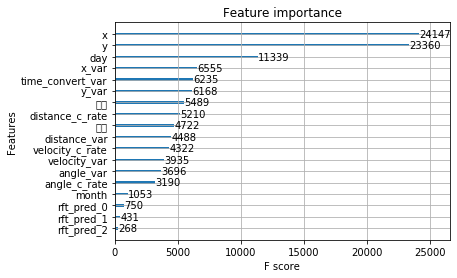

In [0]:
#看起来随机森林预测的并没卵用，甚至比month还要废物？
%matplotlib inline
from xgboost import plot_importance
plot_importance(xgb1)

In [0]:
#xgb在测试集上的结果
xgb1_pred = xgb1.predict(test_rft_proced_x)

In [0]:
xgb1_pred_onehot = onehot(pd.Series(xgb1_pred))
xgb1_pred_onehot.index = test_id.index
xgb1_pred_ = pd.concat([test_id,xgb1_pred_onehot],axis=1)
xgb1_pred_.columns = ['id','0','1','2']
xgb1_pred_ = xgb1_pred_.groupby('id').mean()
test_y = de_one_hot(xgb1_pred_)

In [0]:
test_y.to_csv('result3.csv',header=None,encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [0]:
!cp result3.csv ./drive2/Colab\ Notebooks

尝试验证检验模型效果

In [0]:
#验证集数据标签
test_xgb_y_ = test_xgb_y

In [0]:
#验证集ID
test_xgb_index = pd.Series(list(test_xgb_y.index))
test_xgb_y_ = onehot(test_xgb_y_)

In [0]:
test_xgb_y_.index = test_xgb_index

In [0]:
test_xgb_y_['id'] = test_xgb_index
test_xgb_y__ = test_xgb_y_.groupby('id').mean()

In [0]:
#获得真实的类型
val_result = pd.Series(de_one_hot(test_xgb_y__))

In [0]:
#标记ID
val_result

id
0       刺网
1       围网
4       拖网
6       围网
7       拖网
        ..
6995    拖网
6996    刺网
6997    拖网
6998    拖网
6999    拖网
Length: 4374, dtype: object

In [0]:
test_xgb_x.index

Int64Index([5406, 5318, 2244, 1255, 4630, 5066, 2948, 5913, 2510,  341,
            ...
            3085, 1397,  796, 5274,  408, 1381, 6264, 5044, 2986, 1774],
           dtype='int64', name='渔船ID', length=233645)

In [0]:
val_pred = pd.Series(xgb1.predict(test_xgb_x))

In [0]:
val_pred_index = pd.Series(list(test_xgb_x.index))
val_pred_ = onehot(val_pred)

In [0]:
val_pred_.index = val_pred_index

In [0]:
val_pred_['id'] = val_pred_index
val_pred__ = val_pred_.groupby('id').mean()

In [0]:
val_pred_result = pd.Series(de_one_hot(val_pred__))

In [0]:
val_pred_result.index = val_pred__.index

In [0]:
#交叉验证结果为0.94，但是模型设计时候有个致命缺陷，训练集数据划分是混合到一起划分的 不是按照文件划分，因而会造成数据泄露问题 
#可能导致过拟合现象 等明天看成绩了，有时间修改下数据准备部分 让数据加载快一点 划分时候避开这个缺陷
#而且当前划分方式可能造成数据不均衡问题 即数据多的船只训练时候用到数据多 
#也不排除数据多的可能信号好，数据质量高，对模型有正面影响的可能性
len(val_result[val_pred_result == val_result])/len(val_result)

0.948559670781893